# OpenAI API Labeling for Sequences

In [1]:
from sequence_openai_labeling import *

In [2]:
df = pd.read_csv('../labels_output/labels_lstm.csv')
test_path = df['crop_path'].iloc[0]
full_path = Path(str('../seq_img' + test_path))
print(f"Original path: {test_path}")
print(f"Full path: {full_path}")
print(f"Exists: {full_path.exists()}")

Original path: /gpfs/space/projects/ml2024/2024-08-16-16-03-30_mapping_tartu_streets/camera_narrow_front/predict/crops/car/142120.jpg
Full path: ../seq_img/gpfs/space/projects/ml2024/2024-08-16-16-03-30_mapping_tartu_streets/camera_narrow_front/predict/crops/car/142120.jpg
Exists: True


In [3]:
test_seq = df[df['sequence_id'] == 'seq_0000'].sort_values('frame_idx')
test_paths = [str('../seq_img' + test_path) for p in test_seq['crop_path'].tolist()]
print(f"Testing with {len(test_paths)} frames")
print(f"First frame exists: {Path(test_paths[0]).exists()}")

Testing with 13 frames
First frame exists: True


In [4]:
result_individual = label_sequence_individual_frames(test_paths, model='gpt-4o-mini')
print(json.dumps(result_individual, indent=2))

{
  "label": "none",
  "confidence": 1.0,
  "reasoning": "Throughout all frames, there are no visible turn signals blinking on either side of the vehicle. The lights remain off, indicating that no turn signals are active.",
  "frames_with_signal": [],
  "method": "individual_frames",
  "num_frames": 13,
  "model": "gpt-4o-mini",
  "tokens_used": {
    "prompt": 184502,
    "completion": 50,
    "total": 184552
  }
}


In [4]:
result_grid = label_sequence_grid(test_paths, model='gpt-4o-mini')
print(json.dumps(result_grid, indent=2))

{
  "label": "none",
  "confidence": 0.95,
  "reasoning": "Throughout the sequence, there are no visible amber/orange lights indicating that the turn signals are active. The lights appear to be off in all frames.",
  "frames_with_signal": [],
  "method": "grid",
  "num_frames": 13,
  "model": "gpt-4o-mini",
  "tokens_used": {
    "prompt": 48474,
    "completion": 49,
    "total": 48523
  }
}


In [4]:
results_df = process_all_sequences(
    label_csv='../labels_output/labels_lstm.csv',
    method='both',
    model='gpt-4o-mini',
    output_path='openai_results.json',
    image_base_path='../seq_img' 
)

Processing 21 sequences using method: both
Model: gpt-4o-mini
Image base path: ../seq_img
------------------------------------------------------------

[1/21] Processing seq_0000...
  True label: right
  Frames: 4
  First frame: 142120.jpg
  Running individual frames method...
    Predicted: left
  Running grid method...
    Predicted: left

[2/21] Processing seq_0001...
  True label: left
  Frames: 4
  First frame: 087883.jpg
  Running individual frames method...
    Predicted: none
  Running grid method...
    Predicted: hazard

[3/21] Processing seq_0002...
  True label: left
  Frames: 4
  First frame: 0510122.jpg
  Running individual frames method...
    Predicted: none
  Running grid method...
    Predicted: none

[4/21] Processing seq_0003...
  True label: right
  Frames: 4
  First frame: 0017802.jpg
  Running individual frames method...
    Predicted: none
  Running grid method...
    Predicted: left

[5/21] Processing seq_0004...
  True label: right
  Frames: 4
  First frame: 0

In [5]:
metrics = evaluate_results(results_df)


Individual Frames Method:
  Accuracy: 52.38% (11/21)
  Confusion Matrix:
individual  left  none
true_label            
hazard         0     1
left           2     3
none           1     9
right          2     3

Grid Method:
  Accuracy: 28.57% (6/21)
  Confusion Matrix:
grid        hazard  left  none  right
true_label                           
hazard           0     0     1      0
left             3     1     1      0
none             3     1     5      1
right            3     2     0      0



In [6]:
errors = results_df[
    results_df['individual'].apply(lambda x: x.get('label')) != results_df['true_label']
]
print(f"Found {len(errors)} errors")
for idx, row in errors.iterrows():
    print(f"\nSequence: {row['sequence_id']}")
    print(f"True: {row['true_label']}, Predicted: {row['individual']['label']}")
    print(f"Reasoning: {row['individual']['reasoning']}")

Found 11 errors

Sequence: seq_0000
True: right, Predicted: left
Reasoning: The left amber turn signal is blinking in frames 0, 1, and 2, indicating that it is active. The right turn signal is not blinking in any of the frames, confirming that only the left signal is active.

Sequence: seq_0002
True: left, Predicted: none
Reasoning: There are no amber colored turn signals blinking in any of the frames. The lights are consistently off throughout the sequence.

Sequence: seq_0003
True: right, Predicted: none
Reasoning: No amber colored turn signals are active in any frames. The lights do not blink on either side, indicating that the turn signals are off.

Sequence: seq_0004
True: right, Predicted: hazard
Reasoning: Both left and right turn signals are blinking in the frames, indicating that hazard lights are active.

Sequence: seq_0008
True: right, Predicted: left
Reasoning: The left amber turn signal is blinking in frames 1 and 2, indicating that it is active. The right turn signal is n

# Visualization

In [8]:
import matplotlib.pyplot as plt
import textwrap

In [9]:
def visualize_comparison(
    image_paths: List[str],
    individual_result: Dict,
    grid_result: Dict,
    true_label: str = None,
    figsize: Tuple[int, int] = (18, 12)
):
    fig = plt.figure(figsize=figsize)
    
    # Create grid layout
    gs = fig.add_gridspec(3, 2, height_ratios=[0.15, 1, 0.5], hspace=0.3, wspace=0.2)
    
    # Title
    title_ax = fig.add_subplot(gs[0, :])
    title_ax.axis('off')
    title_text = f"SEQUENCE COMPARISON"
    if true_label:
        title_text += f" | True Label: {true_label.upper()}"
    title_ax.text(0.5, 0.5, title_text, ha='center', va='center', 
                 fontsize=16, fontweight='bold')
    
    # Individual method images
    individual_ax = fig.add_subplot(gs[1, 0])
    individual_ax.axis('off')
    individual_ax.set_title("INDIVIDUAL FRAMES METHOD", fontweight='bold', fontsize=12)
    
    # Create mini grid for individual
    n_images = len(image_paths)
    n_cols = min(3, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    mini_fig_individual = create_image_grid(image_paths, max_cols=n_cols)
    individual_ax.imshow(mini_fig_individual)
    
    # Grid method image
    grid_ax = fig.add_subplot(gs[1, 1])
    grid_ax.axis('off')
    grid_ax.set_title("GRID METHOD", fontweight='bold', fontsize=12)
    
    grid_image = create_image_grid(image_paths, max_cols=min(5, n_images))
    grid_ax.imshow(grid_image)
    
    # Individual results text
    individual_text_ax = fig.add_subplot(gs[2, 0])
    individual_text_ax.axis('off')
    
    ind_text = format_result_text(individual_result, true_label, "Individual")
    individual_text_ax.text(0, 1, ind_text, 
                           verticalalignment='top',
                           fontsize=10,
                           family='monospace',
                           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Grid results text
    grid_text_ax = fig.add_subplot(gs[2, 1])
    grid_text_ax.axis('off')
    
    grid_text = format_result_text(grid_result, true_label, "Grid")
    grid_text_ax.text(0, 1, grid_text,
                     verticalalignment='top',
                     fontsize=10,
                     family='monospace',
                     bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    return fig


def format_result_text(result: Dict, true_label: str = None, method_name: str = "") -> str:
    """Format result dictionary as readable text."""
    text = f"{method_name.upper()} RESULTS\n{'='*40}\n\n"
    
    predicted = result.get('label', 'error').upper()
    
    if true_label:
        match = "✓ CORRECT" if result.get('label') == true_label else "✗ INCORRECT"
        text += f"True: {true_label.upper()}\n"
        text += f"Predicted: {predicted} ({match})\n\n"
    else:
        text += f"Predicted: {predicted}\n\n"
        
    if 'reasoning' in result:
        wrapped = textwrap.fill(result['reasoning'], width=35)
        text += f"Reasoning:\n{wrapped}\n\n"
    
    if 'frames_with_signal' in result:
        text += f"Signal frames: {result['frames_with_signal']}\n\n"
    
    if 'error' in result:
        text += f"\nERROR: {result['error']}\n"
    
    return text

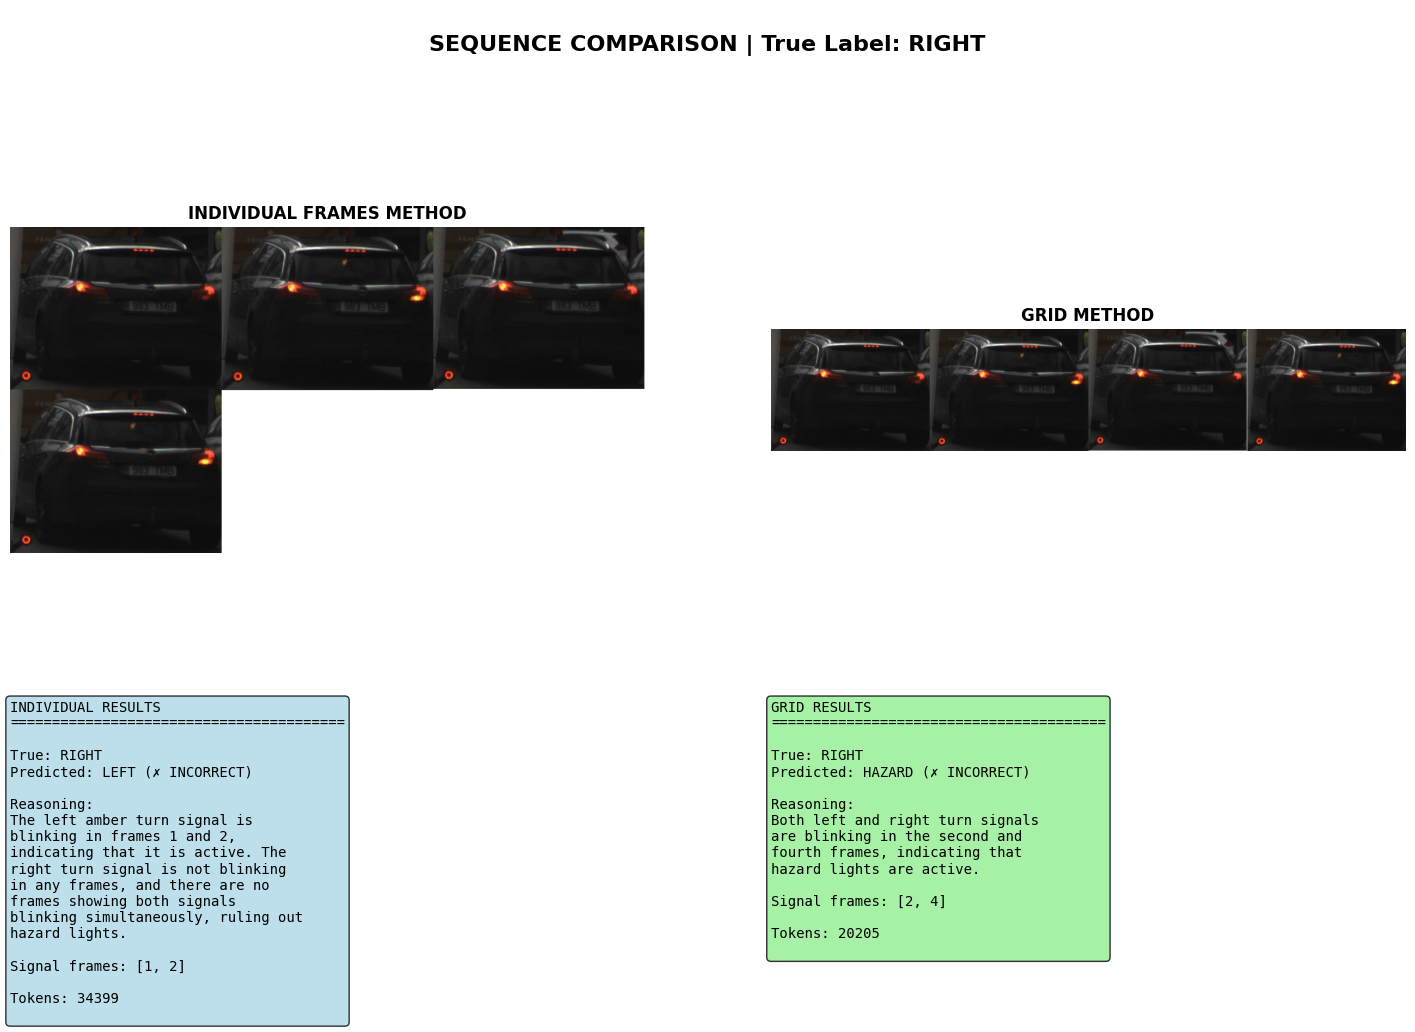

In [12]:
seq_idx = 8  # Change this to view different sequences
row = results_df.iloc[seq_idx]
image_paths = [str(p) for p in row['frame_paths']]

if 'individual' in row and 'grid' in row:
    fig = visualize_comparison(
        image_paths, 
        row['individual'], 
        row['grid'], 
        row['true_label']
    )
    plt.show()

# Cell 11: Analyze only errors with visualization
errors = results_df[
    results_df['individual'].apply(lambda x: x.get('label') if isinstance(x, dict) else None) 
    != results_df['true_label']
]